In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def chi2(T):
    p = T[0]; q = T[1]; r = T[2]; s = T[3]; t = T[4]; u = T[5]
    S = 0
    if p+q != 0:
        S += ((p-q)**2)/(p+q)
    if r+s != 0:
        S += ((r-s)**2)/(r+s)
    if t+u != 0:
        S += ((t-u)**2)/(t+u)
    return S

In [3]:
def DOLS_chi2(x,n,m):
    TG = np.zeros((m,6))
    for i in range(m):
        for j in range(n):
            TG[i][int(x[j][i])] += 1
            
    #Step 1
    MCP = np.zeros((m,6)); MCN = np.zeros((m,6)) #MaxChange
    for i in range(m):
        T = TG[i]
        X = chi2(T); MCP[i] = np.zeros(6); MCN[i] = np.zeros(6)
        if T[0] >= 1:
            Y = chi2([T[0]-1, T[1], T[2]+1, T[3], T[4], T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
            Y = chi2([T[0]-1, T[1], T[2], T[3], T[4]+1, T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
        if T[1] >= 1:
            Y = chi2([T[0], T[1]-1, T[2], T[3]+1, T[4], T[5]])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
            Y = chi2([T[0], T[1]-1, T[2], T[3], T[4], T[5]+1])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
        if T[2] >= 1:
            Y = chi2([T[0]+1, T[1], T[2]-1, T[3], T[4], T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
            Y = chi2([T[0], T[1], T[2]-1, T[3], T[4]+1, T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
        if T[3] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3]-1, T[4], T[5]])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]-1, T[4], T[5]+1])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
        if T[4] >= 1:
            Y = chi2([T[0]+1, T[1], T[2], T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
            Y = chi2([T[0], T[1], T[2]+1, T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
        if T[5] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3], T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]+1, T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
    
    #Step 2
    LSS = np.zeros(int(2**m))
    for j in range(n):
        LSJ = np.zeros((m,int(2**m)))
        LSJ[0][0] = MCP[0][int(x[j][0])]; LSJ[0][1] = MCN[0][int(x[j][0])]
        #print(LSJ[0],LSJ[1])
        for i in range(1,m):
            for k in range(2**i):
                LSJ[i][2*k+0] = LSJ[i-1][k] + MCP[i][int(x[j][i])]
                LSJ[i][2*k+1] = LSJ[i-1][k] + MCN[i][int(x[j][i])]
        #print(LSJ)
        for i in range(int(2**m)):
            LSS[i] = max(LSS[i],LSJ[m-1][i])    
        #print(LSS)
        
    #Step 3
    DOLSP = np.zeros(m) #LS^{i+}
    DOLSN = np.zeros(m) #LS^{i-}
    
    for j in range(m):
        for i in range(int(2**m)):
            if int(i/(2**(m-1-j)))%2 == 0:
                DOLSP[j] = max(DOLSP[j], LSS[i])
            else:
                DOLSN[j] = max(DOLSN[j], LSS[i])
    
    return DOLSP, DOLSN

In [4]:
def h3(z,l):
    return (3*np.sqrt(3)*(l**(2/3)))/(4*math.pi*(math.fabs(z)**3+l))

def cdf(x,h,l):
    g = lambda z: h(z,l)
    return integrate.quad(g,-oo,x)

def noise(h,l,d): # using inverse transform sampling
    r = np.random.rand()
    q = 1000; z = 10
    for i in range(-50,50):
        if math.fabs(r - cdf(i/5,h,l)[0]) > q:
            z = (i-1)/5
            break
        else:
            q = min(q, math.fabs(r - cdf(i/5,h,l)[0]))
    if d == 0:
        return math.fabs(z)
    elif d == 1:
        return -math.fabs(z)
    
def alpha(k,l,m,ei): #epsilon = ei*m
    return ((l**(1/k))*(ei*m))/(2*((k-1)**((k-1)/k)))

In [5]:
def DOSS_chi2_test_positive(n,m):
    x = np.ones((n,m))
    for j in range(m):
        for i in range(int(n/2)):
            if i < 1:
                x[i][j] = 0
            else:
                x[i][j] = 4
        for i in range(int(n/2)):
            if i < 1:
                x[i+int(n/2)][j] = 1
            else:
                x[i+int(n/2)][j] = 3
    DOLSP, DOLSN = DOLS_chi2(x,n,m)
    #LS = max(max(DOLSP), max(DOLSN))
    #print(LS/min(DOLSP), LS/min(DOLSN))
    return DOLSP, DOLSN

def DOSS_chi2_test_negative(n,m):
    x = np.ones((n,m))
    for j in range(m):
        for i in range(int(n/2)):
            if i < 1:
                x[i][j] = 0
            elif i < int((n-2)/4):
                x[i][j] = 2
            else:
                x[i][j] = 4
        for i in range(int(n/2)):
            if i < 1:
                x[i+int(n/2)][j] = 1
            elif i < int((n+2)/4):
                x[i+int(n/2)][j] = 3
            else:
                x[i+int(n/2)][j] = 5
    DOLSP, DOLSN = DOLS_chi2(x,n,m)
    #LS = max(max(DOLSP), max(DOLSN))
    #print(LS/min(DOLSP), LS/min(DOLSN))
    return DOLSP, DOLSN

In [6]:
def accuracy_positive(n,m,DOLSP,DOLSN):
    acc = np.zeros((8,2))
    k = 3; l = 3
    LS = np.zeros(20)
    ei = [15+5*i for i in range(8)]
    
    for j in range(20):
        LS[j] = max(max(DOLSP[j]), max(DOLSN[j]))
        for i in range(8):
            for t in range(m):
                if random.random()<0.5:
                    z = noise(h3,l,0)
                    acc[i][0] += math.fabs((DOLSP[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
    return acc/(m*20)

def accuracy_negative(n,m,DOLSP,DOLSN):
    acc = np.zeros((8,2))
    k = 3; l = 3
    LS = np.zeros(20)
    ei = [15+5*i for i in range(8)]
    
    for j in range(20):
        LS[j] = max(max(DOLSP[j]), max(DOLSN[j]))
        for i in range(8):
            for t in range(m):
                if random.random()<0.5:
                    z = noise(h3,l,1)
                    acc[i][0] += math.fabs((DOLSN[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
    return acc/(m*20)

[[0.24325665 0.36488497]
 [0.16989353 0.2548403 ]
 [0.12742015 0.19113022]
 [0.19113022 0.28669534]
 [0.15941309 0.23911963]
 [0.08301616 0.12452424]
 [0.05834727 0.08752091]
 [0.09537205 0.14305808]]
[[0.25355323 0.38032984]
 [0.24422195 0.36633293]
 [0.11120304 0.16680456]
 [0.14415209 0.21622813]
 [0.10756246 0.1613437 ]
 [0.13321197 0.19981796]
 [0.05534411 0.08301616]
 [0.0891941  0.13379116]]
[[0.4401787  0.66026805]
 [0.17761597 0.26642395]
 [0.17838821 0.26758231]
 [0.14093441 0.21140161]
 [0.10094324 0.15141485]
 [0.08880798 0.13321197]
 [0.11626552 0.17439829]
 [0.06255171 0.09382756]]
[[0.1943479  0.29152186]
 [0.15830988 0.23746482]
 [0.16448783 0.24673174]
 [0.15316159 0.22974239]
 [0.11197528 0.16796292]
 [0.09942633 0.14913949]
 [0.06907288 0.10360931]
 [0.08456064 0.12684097]]
[[0.22523764 0.33785646]
 [0.20657509 0.30986264]
 [0.11738099 0.17607148]
 [0.15316159 0.22974239]
 [0.11087208 0.16630812]
 [0.06515803 0.09773705]
 [0.09352725 0.14029087]
 [0.05560152 0.083402

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


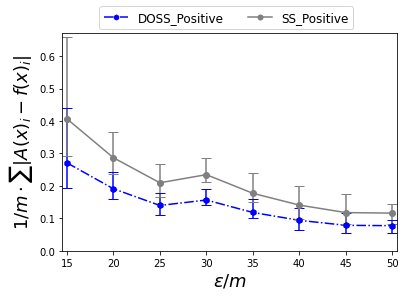

In [7]:
n = 150; m = 3

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOSS_chi2_test_positive(n,m)

jj = 5
for j in range(jj):
    acc = accuracy_positive(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.01)
plt.xlim(14.5, 50.5)
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS_Positive")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS_Positive")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_positive_m=3.png")
fig.savefig("figs/Accuracy_chi2_positive_m=3.eps", bbox_inches="tight", pad_inches=0.05)

[[0.08176572 0.12264857]
 [0.05674405 0.08511608]
 [0.05699851 0.08549776]
 [0.0454631  0.06819464]
 [0.02544576 0.03816864]
 [0.02900817 0.04351225]
 [0.02148753 0.0322313 ]
 [0.01984769 0.02977154]]
[[0.06276621 0.09414932]
 [0.04961924 0.07442885]
 [0.04295245 0.06442867]
 [0.03307949 0.04961924]
 [0.03068032 0.04602048]
 [0.02964431 0.04446647]
 [0.0175293  0.02629395]
 [0.01821917 0.02732875]]
[[0.07667656 0.11501485]
 [0.03893202 0.05839802]
 [0.04600594 0.06900891]
 [0.05377538 0.08066307]
 [0.02384631 0.03576947]
 [0.01819372 0.02729058]
 [0.02657669 0.03986503]
 [0.0288046  0.0432069 ]]
[[0.09296185 0.13944278]
 [0.04631129 0.06946693]
 [0.02951708 0.04427563]
 [0.03324913 0.04987369]
 [0.02966249 0.04449373]
 [0.03905925 0.05858887]
 [0.01402344 0.02103516]
 [0.02809212 0.04213818]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.06955175 0.10432763]
 [0.03435178 0.05152767]
 [0.03379197 0.05068796]
 [0.03562407 0.0534361 ]
 [0.03300679 0.04951018]
 [0.02875371 0.04313057]
 [0.02861235 0.04291852]
 [0.01313001 0.01969502]]
[[0.07674442 0.11511663]
 [0.04519167 0.06778751]
 [0.04185319 0.06277978]
 [0.04023823 0.06035735]
 [0.02852833 0.0427925 ]
 [0.02893183 0.04339775]
 [0.02164586 0.03246879]
 [0.02161872 0.03242808]]


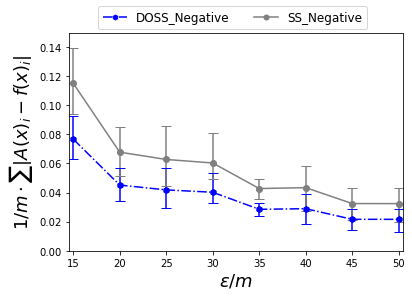

In [8]:
n = 150; m = 3

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOSS_chi2_test_negative(n,m)

jj = 5
for j in range(jj):
    acc = accuracy_negative(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.01)
plt.xlim(14.5, 50.5)
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS_Negative")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS_Negative")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_negative_m=3.png")
fig.savefig("figs/Accuracy_chi2_negative_m=3.eps", bbox_inches="tight", pad_inches=0.05)